# SWC Renderer

<img src="https://reconstrue.github.io/brightfield/content/images/651806289_minip_turbo_banner.png" width="100%" />

<img src="http://reconstrue.com/assets/images/reconstrue_combo_mark.svg" width="266px" />



## Introduction

In neuroscience, skeletons are 3D stick figure models of neurons. A common file format for skeletons is SWC, files with extension `*.swc`. This is the documentation for SWC rendering as performed in the Reconstrue stack.

The SWC format is described. Exploratory data analysis is performed on a sample SWC file. It is then rendered in various ways.

This notebook demonstrates how to generate various renderings of SWC files:
- 2D projection, no depth perception parallaxis ray tracing
  - Make on big image
  - Cutouts and image tiling for `tf.data` to use
- 3D rendering, fixed camera
- Interactive, full-screen volumetric navigation

### Filtering by license

There are some very nice tools which can render SWCs. For example, [NeuroMorphoVis](https://github.com/BlueBrain/NeuroMorphoVis) which is licensed under GPLv3. Unfortunately commercially unfriendly code is not considered for use in the Reconstrue stack, which has an explicit goal of accreting commerically-usable industrial-scale code which any corporation could easily adopt. All pre-existing source code used in this notebook is licensed liberally (Apache, MIT, BSD, etc.).

### Jupyter and Colab 

This notebook has been tested to work on vanilla JupyterLab and on Google Colab. JupyterLab involves some installs, via the standard requirements.txt. On Colab, everything just bootstraps instantly from this single file and any requirements are performed via pip.


This notebook works on Colab, but the notebooks have also been tested to work on JupyterLab. So, this is a Jupyter notebook that will some assembly will work on JupyerLab but it works out-of-the-box on Colab. In this feature space, Colab is simply the strongest free Jupyter hosting service i.e. the "on Colab" part is simply a diffusion of innovation feature, not the main technical deploy target, although it is expected that most usage will occur on Colab, ergo optimize for Colab (certain amounts of memory, certains GPUs, etcetera).

### SWC file spec

SWC is an ASCII text file format. It is tabular and line oriented similar to CSV. 

"SWC are the initials of the last names of E.W. Stockley, H.V. Wheal, and H.M. Cole" [[*](https://www.neuron.yale.edu/phpBB/viewtopic.php?t=3477)]. I guess `*.skl` would have been too obvious?

There is a (weak) formal definition but conformance by tools is sloppy. Provenance is important. Fortunately, in this case the data source is the Allen Institute which does quality technical work. 


According to [AllenSDK on SWC file format spec](https://alleninstitute.github.io/AllenSDK/cell_types.html):
>The SWC file format is a white-space delimited text file with a standard set of headers. The file lists a set of 3D neuronal compartments, each of which has:


Column | Data Type |Description
-- | -- | --
id | string | compartment ID
type | integer | compartment type
x|float|3D compartment position (x)
y|float|3D compartment position (y)
z|float|3D compartment position (z)
radius|float|compartment radius
parent|string|parent compartment ID

>Comment lines begin with a ‘#’. Reconstructions in the Allen Cell Types Database can contain the following compartment types:

Type|Description
--|--
0|unknown
1|soma
2|axon
3|basal dendrite
4|apical dendrite



## Set up

**Install AllenSDK**

(Reconstrue has a separate notebook, [allensdk_on_colab.ipynb](https://colab.research.google.com/github/JohnTigue/colab-utils/blob/master/tools/allensdk_on_colab.ipynb), which deals with nothing except deploying AllenSDK on Colab. That notebook goes into the topic deeper than neccessary here but if complications arise on this front, it has various debug utilities.)


Note: Install hassles on 2020-04-06: 
- allensdk and colab are fighting about pandas version (< 0.25.3 vs. > 1.0)
- Reinstall pandas after allensdk fixes it but requires restart (lame)
- Previous release [pip3 install allensdk==1.5.1](https://pypi.org/project/allensdk/#history) same problem
- Temp solution: fork AllenSDK repo, tweak requirements.txt, `pip install` from github.com



In [1]:
!pip3 install -q git+git://github.com/reconstrue/AllenSDK

     |████████████████████████████████| 2.9MB 3.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 7.4MB 19.9MB/s 
     |████████████████████████████████| 42.5MB 91kB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 3.4MB 43.7MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 4.3MB 41.6MB/s 
     |████████████████████████████████| 1.2MB 41.9MB/s 
     |████████████████████████████████| 112kB 49.3MB/s 
     |████████████████████████████████| 256kB 53.1MB/s 
     |████████████████████████████████| 153kB 52.2MB/s 
     |████████████████████████████████| 552kB 47.3MB/s 


**Install Datashader**

See [datashader_on_colab.ipynb](https://github.com/reconstrue/single_cell_on_colab/blob/master/tools/datashader_on_colab.ipynb) for more details.

[2020-04-05] Can gnore the following:
```
ERROR: distributed 2.14.0 has requirement tornado>=5 since we'll not be using distributed nor tornado.
```

And don't get clever and try to upgrade tornado b/c:
```
ERROR: google-colab 1.0.0 has requirement tornado~=4.5.0
```

In [2]:
!pip3 -q install datashader

     |████████████████████████████████| 15.5MB 195kB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 1.6MB 45.3MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 614kB 53.0MB/s 
ERROR: distributed 2.14.0 has requirement tornado>=5; python_version < "3.8", but you'll have tornado 4.5.3 which is incompatible.


In [3]:
!pip3 -q install spatialpandas

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 63.2MB 136kB/s 


### Imports

In [0]:
import allensdk.core.swc
from allensdk.core.swc import Marker
import datashader as ds  # doctest: +SKIP
import datashader.transfer_functions as tf
from google.colab.data_table import DataTable
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import shapely
from spatialpandas.geometry import PolygonArray
from spatialpandas import GeoDataFrame
import urllib.parse
import PIL


## Fetching SWC files



### Via RESTful RMA
[Cell Types API doc](http://help.brain-map.org/display/celltypes/API#API-download_swc):
>Find the reconstruction file for one of those cells
```
http://api.brain-map.org/api/v2/data/query.json?criteria=
model::NeuronReconstruction
,rma::criteria,[specimen_id$eq313862306],rma::include,well_known_files
```
>Download the reconstruction file
```
http://api.brain-map.org/api/v2/well_known_file_download/491119517
```


Separately, the [Cell Types examples docs](http://help.brain-map.org/display/celltypes/API#API-CellTypesExamples) includes:
>Download the reconstruction file
>`http://api.brain-map.org/api/v2/well_known_file_download/491119517`

So, that is two examples indicating that SWC files can be downloaded via URLs of the form:
```
tp://api.brain-map.org/api/v2/well_known_file_download/<some_id>
```

GETting `491119517` will respond with a document which the server suggests should be named `Sst-IRES-Cre_Ai14-167636.04.01.01_491119515_m.swc`.Note how there are two IDs: `491119517` is the image ID, `491119515` is the cell ID.


The part of the response about relevant files is the array `well_known_files` which will look like:
```javascript
"well_known_files": [
        {
          "attachable_id": 492413272,
          "attachable_type": "NeuronReconstruction",
          "download_link": "/api/v2/well_known_file_download/492413274",
          "id": 492413274,
          "path": "/external/mousecelltypes/prod225/specimen_323865917/Scnn1a-Tg3-Cre_Ai14-172530.06.01.01_492413272_m.swc",
          "well_known_file_type_id": 303941301
        },
        {
          "attachable_id": 492413272,
          "attachable_type": "NeuronReconstruction",
          "download_link": "/api/v2/well_known_file_download/496604572",
          "id": 496604572,
          "path": "/external/mousecelltypes/prod225/specimen_323865917/Scnn1a-Tg3-Cre_Ai14-172530.06.01.01_492413272_marker_m.swc",
          "well_known_file_type_id": 486753749
        },
        {
          "attachable_id": 492413272,
          "attachable_type": "NeuronReconstruction",
          "download_link": "/api/v2/well_known_file_download/487660934",
          "id": 487660934,
          "path": "/external/mousecelltypes/prod225/specimen_323865917/morphology_summary_492413272.png",
          "well_known_file_type_id": 480715721
        }
      ]
```
Seemingly there are always 3 hits and they can only (?) be distinguised by the value of their `path` attribute. From the above example:
- "path": "/external/mousecelltypes/prod225/specimen_323865917/Scnn1a-Tg3-Cre_Ai14-172530.06.01.01_492413272_m.swc",
- "path": "/external/mousecelltypes/prod225/specimen_323865917/Scnn1a-Tg3-Cre_Ai14-172530.06.01.01_492413272_marker_m.swc"
- "path": "/external/mousecelltypes/prod225/specimen_323865917/morphology_summary_492413272.png"

Ignoring the third which is a low res image `*.png`, the other two are `*.swc` files. We do **NOT** want the on ends in  `…marker_m.swc`, which is annoation markers (e.g. points where swc tracing stopped) but "marker_m.swc" is an simpler regex than one involving numericals. The main morphology `*.swc` is the other one. So, filter `*.png` then filter `marker_m.swc` and that pidgeon holes the main `*.swc. file.

Then once we know which of well_known_files[0..2] has `path` of the main skeleton file, we want that one's `id`, which will then be inserted into an HTTP GET request URL.


In [8]:
json_file_name = "/content/response.json"

query_terms = f'model::NeuronReconstruction,rma::criteria,[specimen_id$eq{cell_id}],rma::include,well_known_files'

query_url_root = 'http://api.brain-map.org/api/v2/data/query.json?criteria='
query_encoded = urllib.parse.quote(query_terms)
json_query_url = query_url_root + query_encoded

!wget -O {json_file_name} {json_query_url}

with open(json_file_name) as f:
  eg_data = json.load(f)

print(json.dumps(eg_data, indent=2))

--2020-04-19 07:56:32--  http://api.brain-map.org/api/v2/data/query.json?criteria=model%3A%3ANeuronReconstruction%2Crma%3A%3Acriteria%2C%5Bspecimen_id%24eq500961530%5D%2Crma%3A%3Ainclude%2Cwell_known_files
Resolving api.brain-map.org (api.brain-map.org)... 63.237.233.29
Connecting to api.brain-map.org (api.brain-map.org)|63.237.233.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/content/response.json’

/content/response.j     [ <=>                ]      85  --.-KB/s    in 0s      

2020-04-19 07:56:32 (9.16 MB/s) - ‘/content/response.json’ saved [85]

{
  "success": true,
  "id": 0,
  "start_row": 0,
  "num_rows": 0,
  "total_rows": 0,
  "msg": []
}


In [0]:
# So, from querying above:
swc_id_for_cell_485909730 = 500961530
download_collection_url = 'http://api.brain-map.org/api/v2/well_known_file_download/'
swc_src_url = download_collection_url + str(swc_id_for_cell_485909730)

dest_file_name = "485909730.swc"

downloaded_doc = requests.get(swc_src_url)
with open(dest_file_name, 'wb') as f:
  f.write(downloaded_doc.content)


### Via Allen SDK

## SWC as text file

In the AllenSDK docs there are multiple examples indicating that SWC files can be downloaded via:
```
tp://api.brain-map.org/api/v2/well_known_file_download/<some_id>
```
Note that `some_id` is not a cell ID, rather it is the ID of the `*.swc` file. A (manually discovered) valid image ID (491119517) and its URL is:
> [http://api.brain-map.org/api/v2/well_known_file_download/491119517](http://api.brain-map.org/api/v2/well_known_file_download/491119517)





In [5]:
cell_id = 500961530
src_url = "http://api.brain-map.org/api/v2/well_known_file_download/500961530" + str(500961530)

# first: src_url = "http://api.brain-map.org/api/v2/well_known_file_download/491119517"
swc_file_name = "/content/sample.swc" # /content is default dir

downloaded_doc = requests.get(src_url)
open(swc_file_name, 'wb').write(downloaded_doc.content)

728

In [6]:
print("SWC filename: %s" % swc_file_name)


SWC filename: /content/sample.swc


In [7]:
!head -5 {swc_file_name}


<!DOCTYPE html>
<html>
<head>
  <title>We're sorry, but something went wrong (500)</title>
  <style type="text/css">


## SWC in DataFrame

One way to "pass arrays" would be to load the data into a Pandas DataFrame. Pandas and Matplotlib are supposedly well-integrated.

The skeleton files, `*.swc`, are textual and can be loaded into a DataFrame via `readcsv()`


The hashtags are supposed to be comment header, so code should ignore the first three lines. Basically, an SWC file is similar to a CSV file: textual, line-oriented but with spaces for separators rather than commas. Colab has a custom DataTable, so load the SWC data structure into a DataTable.



In [11]:
# Load data from SWC file into a Panda's DataFrame, the view via google.colab.data_table.DataTable


segments = pd.read_csv(dest_file_name, sep=" ", names=["id", "type", "x", "y", "z", "r", "pid"], skiprows=[0,1,2], index_col=0)
segments.dtypes

type      int64
x       float64
y       float64
z       float64
r       float64
pid       int64
dtype: object

In [13]:
DataTable(segments)
#segments

,type,x,y,z,r,pid
id,,,,,,
1,1,375.2331,548.5594,19.3472,4.8620,-1
2,3,378.4707,550.3155,23.5206,0.2185,1
3,3,379.2429,551.0168,24.3400,0.3390,2
4,3,379.9785,551.8713,25.0228,0.2632,3
5,3,380.9749,552.4079,25.4406,0.2023,4
...,...,...,...,...,...,...
1921,3,298.7041,603.1957,52.2124,0.1342,1920
1922,3,297.5716,603.2930,52.5426,0.1313,1921
1923,3,296.4493,603.1191,52.8357,0.1271,1922


TODO: fold in:

Row `ID`==1 has `type` = `1` which means "soma." Notice how there is only one type == `1` row. So the `r` is the radius they use for the spherical representation of a soma. Note that in this example the radius of the soma is over 20 times the diameter of the stems that branch off it. E.g.:



The column `pid` is for parent ID. Notice how the row with id==1 has `pid` of -1, meaning it is the root/soma, and the tree grows off it; all other rows' `pid` will have a positive integer, a key to the `id` of its parent in the tree.

So each row/segment defines its parent ID segment, the endpoint of which is uses at the start point (x,y,z) of this row's 3D line segment, and this row defines the other end of this segment (x,y,z). 

The column `r` is for the radius. In the case of this dataset, the radii seem to actually represent the diameter of the reconstructed neurites. These skeletons are not just stick figure graphs; each segment has meat, the volume defined by `r`. 

This will be very useful for treating the skeletons as a source of ground truth data. Those radii can be turned into a mask or a mesh and be used as feedback labels for training classifier as to a voxel being inside or outside a cell's membrane.

**Essentially, the core SWC data structure is a 3D tree of spheres located at (`x`, `y`, `z`) and of size `r`. For rendering, edges between any 2 spheres are skinned in a straight tube which at its ends has the same diameter as that of the sphere it ends at.**

#### Radii of neurites

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36f9dfe7b8>]],
      dtype=object)

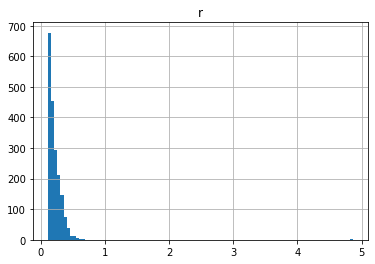

In [14]:
# TODO: plot out x,y,z histograms
#       https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
segments.hist(column='r', bins=100)

#### Bounding box

Below, this bounding box can be used to crop plate images (raw or projections) to the region of interest. The format for the cropbox is how much to crop from each side: ((top, bottom), (left, right))

In [15]:
maxs = segments.max(axis=0)
mins = segments.min(axis=0)

crop_top = mins["y"]
crop_right = maxs["x"]
crop_bottom = maxs["y"]
crop_left = mins["x"]

skeletons_crop_box = ((crop_top, crop_bottom), (crop_left, crop_right))
print(skeletons_crop_box)

((122.6322, 663.6241), (202.5063, 472.4903))


## SWC as 2D images

[Developement tracked in [#190](https://github.com/reconstrue/brightfield/issues/190).]

The Allen Institute has the Allen SDK, which has code for parsing `*.swc` files and a data model (`Morphology`) with utility functions for manipulating skeletons.

First thing to do is what The Allen has in their own SDK docs: [Cell Types examples](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html#Cell-Morphology-Reconstructions). The following code cell is derived from that notebook:




Total number of compartents about to (slowly) plot: 1925


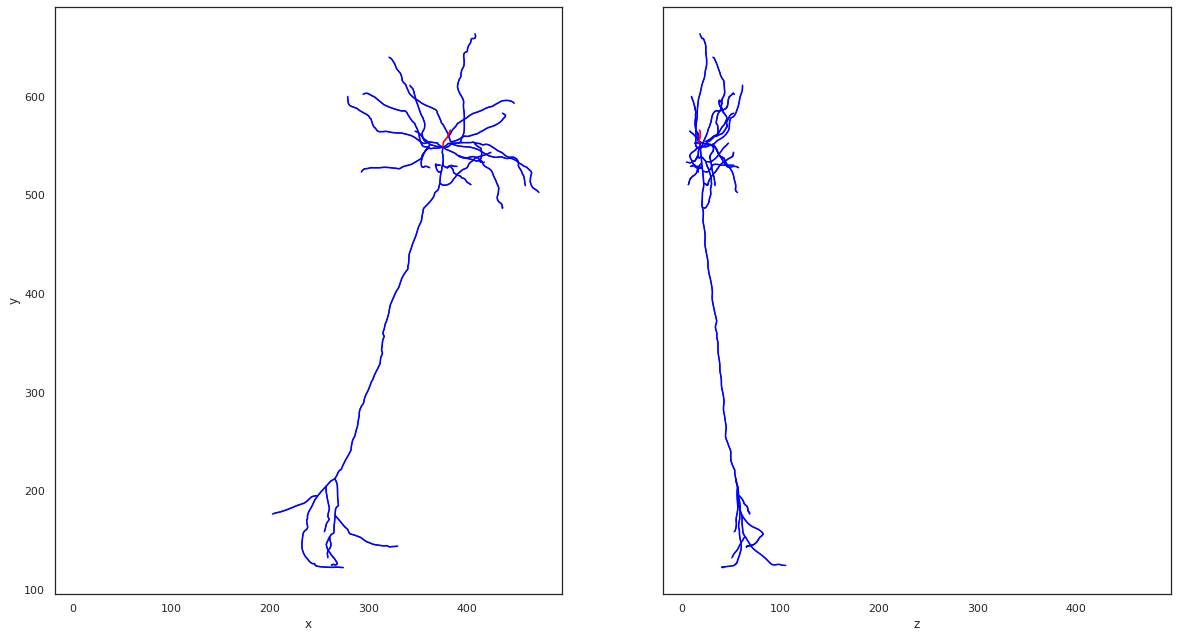

CPU times: user 4.79 s, sys: 72.7 ms, total: 4.86 s
Wall time: 4.87 s


In [17]:
%%time

# https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/swc.html
morphology = allensdk.core.swc.read_swc(dest_file_name)
print("Total number of compartents about to (slowly) plot: %d..." % len(morphology.compartment_list))

sns.set(style="white")

fig, axes = plt.subplots(1, 2, figsize=(20,20), sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box') # 'box-forced'

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        if c["type"] == 2:
            skeleton_color = "red"
        else:
            skeleton_color = "blue"
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color=skeleton_color)
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color=skeleton_color)

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
# TODO: legend of blue & red. Title.
plt.show()

pass # suppress <output noise>


So, that shows folks how to use `allensdk` to get a SWC file and render it via Python.

But the SDK doesn't have dedicated machinery for viewing the SWCs beyond the above Matplotlib demo. A Matplotlib demo is great pedogoically. Next, let's dial that in for performance, somehow worked out "on Colab."

**TODO:** Nonetheless, the code rather slow. As is `plot()` is being called on SWC segment at a time. Perhaps there a way to pass arrays to `plot()`?

### Datashader 2D points

Late in 2019 Datashader added `polygons()` ([source code](https://datashader.org/_modules/datashader/core.html)).

CPU times: user 20.7 ms, sys: 121 µs, total: 20.8 ms
Wall time: 24.6 ms


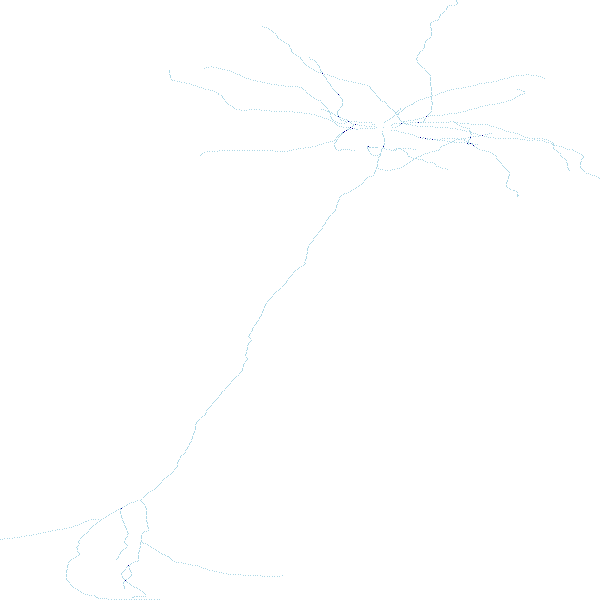

In [19]:
import datashader as ds
import datashader.transfer_functions as tf

%time tf.shade(ds.Canvas().points(segments,'x','y'))


In [20]:
polygon = shapely.geometry.Polygon([(0, 0), (1, 1), (1, 0)]) 
print(polygon.exterior.is_ccw) # False
polygon = shapely.geometry.Polygon([(0, 0), (1, 0), (1, 1)])
print(polygon.exterior.is_ccw) # True


False
True


In [0]:
#polygon = c([(0, 0), (1, 1), (1, 0)]) 
#print(polygon.exterior.is_ccw) # False
#polygon = shapely.geometry.Polygon([(0, 0), (1, 0), (1, 1)])
#print(polygon.exterior.is_ccw) # True

def project_to_2d_polygon(s1, s2):
  """ SWC is a tree of spheres. This takes in two directly
  connected spheres and draws the tube connecting their cross-sectional
  diameter circles (a cylinder with ends of different radii). That
  is projected to 2D, without parallaxis or such; rather simply
  ingore the Z axis and colapse 3D to 2D. That reduces to some 4
  vertex polygon. The return data structure is suitable for input to
  Datashader for plotting."""  

  delta_x = s1['x'] - s2['x']
  if delta_x == 0:
    delta_x = 0.00000001

  delta_y = s1['y'] - s2['y']
  if delta_y == 0:
    delta_y = 0.00000001

  #angle = math.atan(delta_y/delta_x)
  angle = math.atan(delta_x/delta_y)
  #print(angle)

  #v0 = ((s1['x'] + (math.sin(angle) * s1['radius'])), s1['y'] - (math.cos(angle) * s1['radius']) )
  #v1 = ((s1['x'] - (math.sin(angle) * s1['radius'])), s1['y'] + (math.cos(angle) * s1['radius']) )
  #v2 = ((s2['x'] + (math.sin(angle) * s2['radius'])), s2['y'] - (math.cos(angle) * s2['radius']) )
  #v3 = ((s2['x'] - (math.sin(angle) * s2['radius'])), s2['y'] + (math.cos(angle) * s2['radius']) )
  v0 = ((s1['x'] + (math.cos(angle) * s1['radius'])), s1['y'] - (math.sin(angle) * s1['radius']) )
  v1 = ((s1['x'] - (math.cos(angle) * s1['radius'])), s1['y'] + (math.sin(angle) * s1['radius']) )
  v2 = ((s2['x'] + (math.cos(angle) * s2['radius'])), s2['y'] - (math.sin(angle) * s2['radius']) )
  v3 = ((s2['x'] - (math.cos(angle) * s2['radius'])), s2['y'] + (math.sin(angle) * s2['radius']) )
  #print(v0,v1,v2,v3)

  one_walk = shapely.geometry.Polygon([v0, v1, v3, v2])
  other_walk = shapely.geometry.Polygon([v0, v2, v3, v1])
  #print(one_walk.exterior.is_ccw)
  #print(other_walk.exterior.is_ccw)

  # Datashader wants vertices listed clockwise not ccw (couter clock wise)
  if one_walk.exterior.is_ccw:
    return [v0[0],v0[1],v1[0],v1[1],v3[0],v3[1],v2[0],v2[1],v0[0],v0[1]]
  else:
    return [v0[0],v0[1],v2[0],v2[1],v3[0],v3[1],v1[0],v1[1],v0[0],v0[1]]

  # Looks like, turning clockwise: [ 0,0, 1,1, 2,2, 3,3, 0,0]
  #return np.concatenate((v0, v1, v2, v3, v0))

#356.5586 288.9744 346.315  288.9744 351.931  284.7382 351.0158 284.7382
# 356.5586 288.9744]

In [22]:
# Make a line drawing of x-y and y-z views
projections = []

import datashader.utils

# TODO: refind soma i.e. type==1, which usually is solo
# https://shapely.readthedocs.io/en/latest/code/simplify.py
# https://shapely.readthedocs.io/en/latest/manual.html#object.simplify
# or maybe
# https://shapely.readthedocs.io/en/latest/manual.html#object.simplify

import itertools
head_compartments = itertools.islice(morphology.compartment_list, 30)

for n in morphology.compartment_list:
#for n in head_compartments:
  for c in morphology.children_of(n):
    # print(c)
    if c["type"] == 2:
      skeleton_color = "red"
    else:
      skeleton_color = "blue"

    #v0 = [(n['x'] + n['radius']), n['y']]
    #v1 = [(n['x'] - n['radius']), n['y']] 
    #v2 = [(c['x'] + c['radius']), c['y']]
    #v3 = [(c['x'] - c['radius']), c['y']]
  
    #[ 0,0, 1,1, 2,2, 3,3, 0,0]
    # old, diamonds: compartment_projection = np.concatenate((v0, v1, v2, v3, v0))

    # TODO: JFT the new way
    compartment_projection = project_to_2d_polygon(n, c)
    #print(compartment_projection)

    projections.append(compartment_projection)

polygons = PolygonArray([projections])

df = GeoDataFrame({'polygons': polygons, 'v': range(len(polygons))})

#(5744, 7583)
#5744 7583

#5762x9443
cvs = ds.Canvas(plot_width=5762, plot_height=9443)
agg = cvs.polygons(df, geometry='polygons', agg=ds.sum('v'))
the_image = tf.shade(agg)
datashader.utils.export_image(the_image, filename='/content/swc_as_image')


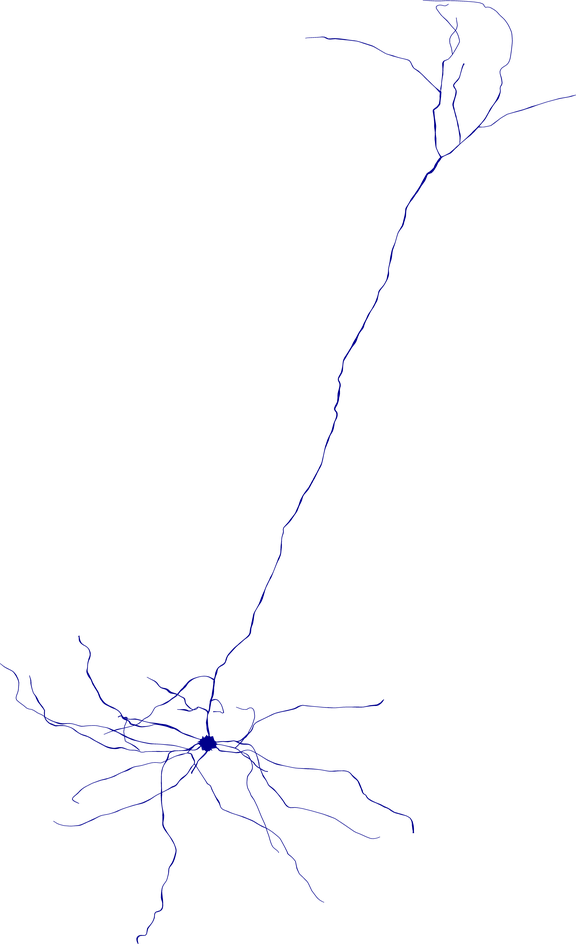

In [23]:
#!ls

file_name = 'swc_as_image.png'
foo = PIL.Image.open(file_name)
x, y = foo.size
x2, y2 = math.floor(x/10), math.floor(y/10)
foo = foo.resize((x2,y2),PIL.Image.ANTIALIAS)

from IPython.display import display as ipy_display
import PIL.ImageOps
#display(foo)

display(PIL.ImageOps.mirror(PIL.ImageOps.flip(foo)))

#'/content/swc_as_image.png'

## SWC in 3D views

The real goal is to get an interactive 3D viewer going for SWCs. Alternatively, a 3D rendering could be to a static image. Idealy the interactive 3D viewer will be able to take snapshots from any perspective and save to a file.

### Priort art

The following image was published by the Allen Instiutute.

![](https://cdn.psychologytoday.com/sites/default/files/styles/image-article_inline_full_caption/public/field_blog_entry_images/2017-10/pyramidal_cell_detail.jpg?itok=iPiTb5Nq)


Notes:
- There is a light source and shadows. 
- The ping pong ball is a limitation of SWC format
- Not sure what the blue is 

In an SWC skeleton model, all segments form a tree; segments are tube/cylinders defined by two linked spheres i.e. a pair of (x,y,z,r) tuples. The root of the tree – not having a parent – is not a tube/cylinder, rather it has only one "end point" so it gets rendered as a sphere instead of a tube.


### Plotly

Plotly is a great toolset which works smoothly on Colab. It has some nice 3D capabilities.


#### Point cloud

First quick and dirty thing that can be done is to just 3D plot the (x,y,z) data as points, no line segments between points.



https://plotly.com/python/builtin-colorscales/

OK:
- phase
- portland
- balance
- bluered
- edge (grayscale-ish, but yellow too)


In [24]:
import plotly.express as px
from plotly.colors import sequential
#import plotly.graph_objs as go
#iris = px.data.iris()

fig = px.scatter_3d(segments, x='x', y='y', z='z',
              color='type', size='r', size_max=18,
              opacity=1.0,color_continuous_scale='phase')


# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(plot_bgcolor='#ff0000') #,height=5000, width=5000)


# https://plotly.com/python/3d-axes/
fig.update_layout(coloraxis=dict(showscale=False),
                 scene = dict(
                    xaxis = dict(
                         nticks=1,
                         backgroundcolor="white",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",),
                    yaxis = dict(
                         nticks=1,
                        backgroundcolor="white",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white"),
                    zaxis = dict(
                         nticks=1,
                        backgroundcolor="white",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

Next, naively add line segments between points. That doesn't work so well because the parent-child data is not being used, so long straight line segments jumping between neurite branch ends.

In [25]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

fig = go.Figure(data=[go.Scatter3d(x=segments['x'], y=segments['y'], z=segments['z'],
                                   mode='lines+markers',
                                   marker=dict(size=1, color=0, colorscale='Viridis', opacity=0.8)
                                   )


   ])
fig.show()

#### Streamtubes

[This sections is a work in progress. It's starting to look like the conclusion might be: Well, streamtubes are cool and rather neurite like, but this is looking more like evidence that Plotly might well do a good job on a full SWC model but that direct low level coding is in order, going lower and bypassing streamtubes.]

Streamtubes are very promising in terms so data model and UI in-browser performance on demo streamtube data. But translating between SWC data model and streamtube data model has not been worked out yet. It might be a bit of a waste and there are other avenues to explore first which might render mute such dev efforts.

[Streamtune API docs](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Streamtube.html)




In [26]:
import plotly
plotly.__version__

'4.4.1'

In [27]:
# Peek inside a CSV, which is the used to drive a basic demo
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-basic.csv')
DataTable(df)

,u,v,w,x,y,z
0,1.000000,1.000000,0.000000,0,0,0
1,1.000000,1.000000,0.088656,0,0,1
2,1.000000,1.000000,0.169393,0,0,2
3,1.000000,0.540302,0.000000,0,1,0
4,1.000000,0.540302,0.088656,0,1,1
5,1.000000,0.540302,0.169393,0,1,2
6,1.000000,-0.416147,0.000000,0,2,0
7,1.000000,-0.416147,0.088656,0,2,1
8,1.000000,-0.416147,0.169393,0,2,2
9,1.841471,1.000000,0.000000,1,0,0


In [28]:
# via https://plotly.com/python/v3/streamtube-plot/#starting-position-and-segments
from plotly.offline import iplot
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-basic.csv')

data = [go.Streamtube(
    x = df['x'],
    y = df['y'],
    z = df['z'],
    u = df['u'],
    v = df['v'],
    w = df['w'],
#    starts = dict(
#        x = [80] * 16,
#        y = [20,30,40,50] * 4,
#        z = [0,0,0,0,5,5,5,5,10,10,10,10,15,15,15,15]
#    ),
    sizeref = 0.3,
    colorscale = 'Portland',
    showscale = False,
    maxdisplayed = 3000
)]

layout = go.Layout(
    scene = dict(
        aspectratio = dict(
            x = 2,
            y = 1,
            z = 0.3
        )
    ),
    margin = dict(
        t = 20,
        b = 20,
        l = 20,
        r = 20
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="streamtube wind")

In [29]:
# https://plotly.com/python/streamtube-plot/

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

x, y, z = np.mgrid[0:10, 0:10, 0:10]
x = x.flatten()
y = y.flatten()
z = z.flatten()

print(y) 

u = np.zeros_like(x)
v = np.zeros_like(y)
w = z**2

fig = make_subplots(rows=1, cols=3, specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d':True}]])

fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=u, v=v, w=w), 1, 1)
fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=w, v=v, w=u), 1, 2)
fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=u, v=w, w=v), 1, 3)

fig.update_layout(scene_camera_eye=dict(x=2, y=2, z=2),
                  scene2_camera_eye=dict(x=2, y=2, z=2),
                  scene3_camera_eye=dict(x=2, y=2, z=2))
fig.show()

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8
 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9
 9 9 9 9 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8
 8 8 8 8 8 8 8 8 8 9 9 9 

In [30]:
# https://plotly.com/python/v3/streamtube-plot/#basic-streamtube-plot
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-wind.csv').drop(['Unnamed: 0'],axis=1)

data = [go.Streamtube(
    x = df['x'],
    y = df['y'],
    z = df['z'],
    u = df['u'],
    v = df['v'],
    w = df['w'],
    starts = dict(
        x = [80] * 16,
        y = [20,30,40,50] * 4,
        z = [0,0,0,0,5,5,5,5,10,10,10,10,15,15,15,15]
    ),
    sizeref = 0.3,
    colorscale = 'Portland',
    showscale = False,
    maxdisplayed = 3000
)]

layout = go.Layout(
    scene = dict(
        aspectratio = dict(
            x = 2,
            y = 1,
            z = 0.3
        )
    ),
    margin = dict(
        t = 20,
        b = 20,
        l = 20,
        r = 20
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="streamtube wind")

## Appendices

### License

This code is [licensed by Reconstrue under the Apache 2.0 License](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/blob/master/LICENSE).


In [0]:
# Copyright 2019-2020 Reconstrue Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

### Tests

The idea here is to have a very simple test harness for running tests on code from within this notebook. And the same tests should work if the code in this `*.ipynb` is exported to `*.py`.
 